***Mohamed Ayman EL-Halmoushy***

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2

labels_url = "https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt"
labels = requests.get(labels_url).text.splitlines()

model_url = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"
model = hub.load(model_url)
print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
pip install tf-models-official


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 11.2 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=3117a08a443752590836297e649ca980723fb2e4cd4800efcae4edc11ac4bc89
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [ ]:
print(model.signatures.keys())

KeysView(_SignatureMap({'serving_default': <ConcreteFunction (*, input_tensor: TensorSpec(shape=(1, None, None, 3), dtype=tf.uint8, name='input_tensor')) -> Dict[['raw_detection_boxes', TensorSpec(shape=(1, 1917, 4), dtype=tf.float32, name='raw_detection_boxes')], ['detection_multiclass_scores', TensorSpec(shape=(1, 100, 91), dtype=tf.float32, name='detection_multiclass_scores')], ['detection_classes', TensorSpec(shape=(1, 100), dtype=tf.float32, name='detection_classes')], ['detection_boxes', TensorSpec(shape=(1, 100, 4), dtype=tf.float32, name='detection_boxes')], ['raw_detection_scores', TensorSpec(shape=(1, 1917, 91), dtype=tf.float32, name='raw_detection_scores')], ['num_detections', TensorSpec(shape=(1,), dtype=tf.float32, name='num_detections')], ['detection_anchor_indices', TensorSpec(shape=(1, 100), dtype=tf.float32, name='detection_anchor_indices')], ['detection_scores', TensorSpec(shape=(1, 100), dtype=tf.float32, name='detection_scores')]] at 0x7F357EFABDD0>}))


In [ ]:
class_names = [
    'person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck',
    'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench',
    'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
    'N/A', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant',
    'bed', 'dining table', 'toilet', 'N/A', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair drier', 'toothbrush'
]
for idx, label in enumerate(class_names):
    print(f'{idx}: {label}')

0: person
1: bicycle
2: car
3: motorbike
4: aeroplane
5: bus
6: train
7: truck
8: boat
9: traffic light
10: fire hydrant
11: N/A
12: stop sign
13: parking meter
14: bench
15: bird
16: cat
17: dog
18: horse
19: sheep
20: cow
21: elephant
22: bear
23: zebra
24: giraffe
25: N/A
26: backpack
27: umbrella
28: handbag
29: tie
30: suitcase
31: frisbee
32: skis
33: snowboard
34: sports ball
35: kite
36: baseball bat
37: baseball glove
38: skateboard
39: surfboard
40: tennis racket
41: bottle
42: wine glass
43: cup
44: fork
45: knife
46: spoon
47: bowl
48: banana
49: apple
50: sandwich
51: orange
52: broccoli
53: carrot
54: hot dog
55: pizza
56: donut
57: cake
58: chair
59: couch
60: potted plant
61: bed
62: dining table
63: toilet
64: N/A
65: tvmonitor
66: laptop
67: mouse
68: remote
69: keyboard
70: cell phone
71: microwave
72: oven
73: toaster
74: sink
75: refrigerator
76: book
77: clock
78: vase
79: scissors
80: teddy bear
81: hair drier
82: toothbrush


In [ ]:
def capture_image():
    display(Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            video.style.display = 'none';
            document.body.appendChild(video);
            await navigator.mediaDevices.getUserMedia({video: true}).then(stream => {
                video.srcObject = stream;
                return new Promise(resolve => video.onloadedmetadata = resolve);
            });
            video.play();
            await new Promise(resolve => setTimeout(resolve, 1000));
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            video.srcObject.getTracks().forEach(track => track.stop());
            document.body.removeChild(video);
            return canvas.toDataURL('image/jpeg', 0.8);
        }
        captureImage();
    '''))
    image_data_url = eval_js('captureImage()')
    image_bytes = b64decode(image_data_url.split(',')[1])
    img = Image.open(BytesIO(image_bytes))
    return img


In [ ]:
# Gaussian Filter for noise reduction
def denoise_image(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

In [ ]:
# Canny function for edge detection
def edge_detection(image):
    return cv2.Canny(image, 100, 200)

In [ ]:
# Fourier function
def apply_fourier_transform(frame):
    f = np.fft.fft2(frame)
    fshift = np.fft.fftshift(f)
    rows, cols = frame.shape
    crow, ccol = rows // 2, cols // 2
    # eliminate low frequencies
    fshift[crow-30:crow+30, ccol-30:ccol+30] = 0
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return np.uint8(img_back)

In [ ]:
def morphological_processing(image):
    kernel = np.ones((5, 5), np.uint8)
    dilated_image = cv2.dilate(image, kernel, iterations=1)
    return dilated_image

In [ ]:
# Function to run object detection
def detect_objects(frame):
    input_tensor = tf.convert_to_tensor(np.array(frame))
    input_tensor = input_tensor[tf.newaxis, ...]

    detections = model(input_tensor)

    bboxes = detections["detection_boxes"][0].numpy()  # Bounding boxes
    class_ids = detections["detection_classes"][0].numpy().astype(int)  # Class IDs
    scores = detections["detection_scores"][0].numpy()  # Confidence scores

    return bboxes, class_ids, scores


<IPython.core.display.Javascript object>

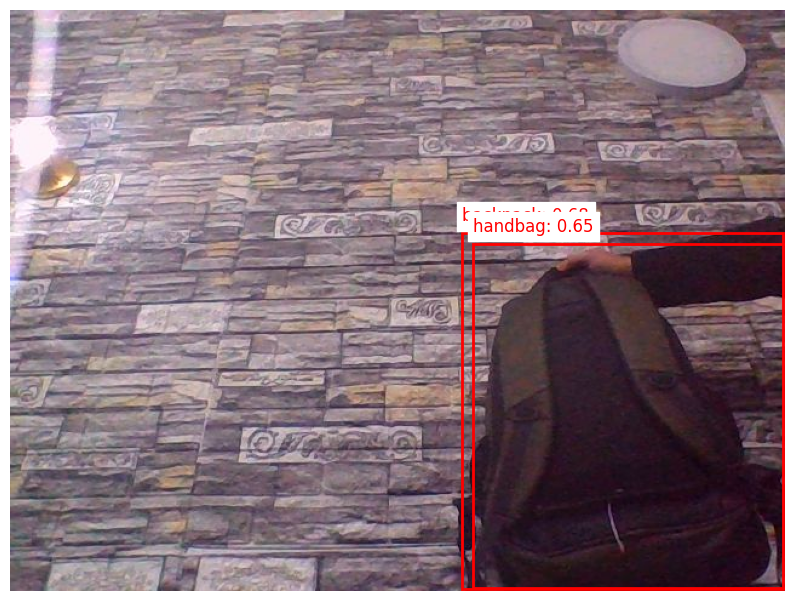

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

CONFIDENCE_THRESHOLD = 0.5

def capture_and_detect():
    # Capture a single frame from the webcam
    img = capture_image()
    frame = np.array(img)

    # Run object detection
    bboxes, class_ids, scores = detect_objects(frame)

    # Draw bounding boxes and labels on the frame
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(frame)

    height, width, _ = frame.shape
    for bbox, class_id, score in zip(bboxes, class_ids, scores):
        if score > CONFIDENCE_THRESHOLD:
            ymin, xmin, ymax, xmax = bbox
            left, top, right, bottom = int(xmin * width), int(ymin * height), int(xmax * width), int(ymax * height)

            # Adjust label index
            adjusted_class_id = class_id - 1
            label = f"{labels[adjusted_class_id]}: {score:.2f}" if adjusted_class_id >= 0 else "Unknown"

            # Draw bounding box
            rect = plt.Rectangle((left, top), right - left, bottom - top, fill=False, color="red", linewidth=2)
            ax.add_patch(rect)
            plt.text(left, top - 10, label, color="red", fontsize=12, backgroundcolor="white")

    # Show the image with detections
    plt.axis("off")
    plt.show()

# Run the function once
capture_and_detect()


In [ ]:
run_real_time_detection()